# MLP with pretrained glove Embedding

In [68]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
import pandas as pd
import numpy as np

### Reading Preprocessed data

In [69]:
twDF = pd.read_csv("Dataset/tweets_preprocessed.csv").drop(['Unnamed: 0'],axis=1)
twDF.head()

,tweet_id,airline_sentiment,negativereason,airline,text_clean
0,570306133677760513,0,NaN,Virgin America,dhepburn said
1,570301130888122368,0,NaN,Virgin America,plus added commercials experience tacky
2,570301083672813571,0,NaN,Virgin America,not today must mean need take another trip
3,570301031407624196,1,Bad Flight,Virgin America,really aggressive blast obnoxious entertainmen...
4,570300817074462722,1,Can't Tell,Virgin America,really big bad thing


In [70]:
# Converting cleaned text to list for further processing
corpus = twDF['text_clean'].tolist()
corpus[:5]

['dhepburn said',
 'plus added commercials experience tacky',
 'not today must mean need take another trip',
 'really aggressive blast obnoxious entertainment guests faces amp little recourse',
 'really big bad thing']

### Removing less frequent words

In [71]:
#https://stackoverflow.com/questions/57179045/how-to-remove-less-frequent-words-from-pandas-dataframe/57179318
all_ = [x for y in corpus for x in y.split(' ') ]
a,b = np.unique(all_, return_counts = True)
to_remove = a[b<4]
corpus = [' '.join(np.array(y.split(' '))[~np.isin(y.split(' '), to_remove)]) for y in corpus]

In [72]:
target = twDF['airline_sentiment'].values

In [73]:
all_ = [x for y in corpus for x in y.split(' ') ]
a,b = np.unique(all_, return_counts = True)
print("number of unique words in corpus are",len(a))

number of unique words in corpus are 3537


### Tokenization and obtaining padded sequences

In [74]:
tok = Tokenizer()
tok.fit_on_texts(corpus)
input_len = len(tok.word_index) + 1

In [75]:
print("Type of tok.word_index is",type(tok.word_index))
iterator = iter(tok.word_index.items())
for i in range(5):
    print(next(iterator))

Type of tok.word_index is <class 'dict'>
('flight', 1)
('not', 2)
('no', 3)
('get', 4)
('co', 5)


**Notes:**

1.Tokenizer fits on our corpus

2.Tokenizer creates a dictionary,mapping words to integers

In [76]:
# encoding our corpus
corp_enc = tok.texts_to_sequences(corpus)
print(corp_enc[:5])

[[136], [443, 1004, 2341, 114], [2, 34, 646, 463, 25, 81, 77, 108], [64, 866, 2973, 15, 388, 2590], [64, 360, 128, 369]]


**Notes:**

1.Tokenizer converts each sentence in corpus into a list of integers(sequence)

2.Its a list of lists where every list inside list has different length

In [77]:
max_length = len(max(corpus, key = len).split(" "))
max_length

21

In [78]:
corp_pad = pad_sequences(corp_enc, maxlen=max_length, padding='post')
print(corp_pad)

[[ 136    0    0 ...    0    0    0]
 [ 443 1004 2341 ...    0    0    0]
 [   2   34  646 ...    0    0    0]
 ...
 [  24  533  344 ...    0    0    0]
 [ 275   59    1 ...    0    0    0]
 [ 205  727   25 ...    0    0    0]]


**Notes:**

1.max_length is the length of longest sentence in our corpus after removing less frequent words

2.All sequences are padded to this length

### Getting glove vectors for our corpus

In [79]:
import pickle
with open('glove_vectors', 'rb') as f:
    glove_vec = pickle.load(f)
type(glove_vec)

dict

In [80]:
glove_emb = zeros((input_len, 300))
for word, i in tok.word_index.items():
    glove_corp = glove_vec.get(word)
    if glove_corp is not None:
        glove_emb[i] = glove_corp

In [81]:
glove_emb.shape

(3537, 300)

## Modeling with keras embedding layer

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(corp_pad, target, test_size=0.33, random_state=42, stratify=target)

In [96]:
import keras
from keras.layers import Dropout

opt = keras.optimizers.Adam(learning_rate=0.00001)
model = Sequential()
vector_size = 300
#max_length = 40
model.add(Embedding(input_len, vector_size, weights=[glove_emb], input_length=max_length, trainable=False))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[keras.metrics.Recall()])
# summarize the model
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 21, 300)           1061100   
_________________________________________________________________
flatten_5 (Flatten)          (None, 6300)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               630100    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 1,691,301
Trainable params: 630,201
Non-trainable params: 1,061,100
_________________________________________________________________
None


In [97]:
result=model.fit(X_train, y_train,validation_split=0.33, epochs=10,verbose=0,batch_size=64)

In [98]:
loss, recall = model.evaluate(X_test, y_test, verbose=0)
print('recall:',recall)

recall: 0.9079122543334961


### Plotting training history

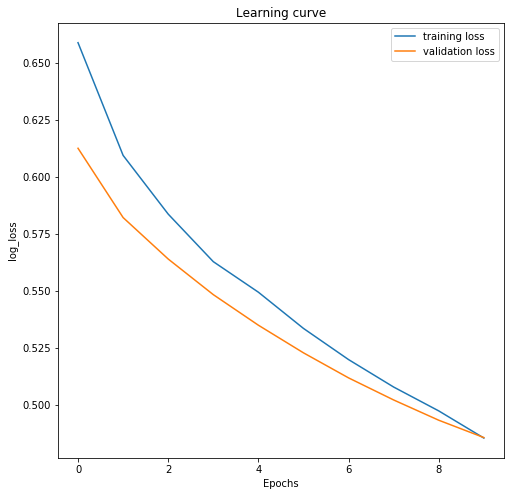

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(result.history["loss"], label="training loss")
plt.plot(result.history["val_loss"], label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

#### A recall of 0.907 is obtained